In [1]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, CuDNNLSTM, RNN, GRU
from tensorflow.python.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
file_name = "../data/all_part"
dataframe = pd.read_csv(file_name, sep="\t")
all_data = dataframe.iloc[:, -1].values

TIMESTEP = 20
TRAINING_STEPS = 10000


In [3]:
dataframe.iloc[:10, -1]

0    2824.303102
1    2823.491818
2    2798.935017
3    2811.224173
4    2782.819729
5    2791.764161
6    2849.966686
7    2848.203796
8    2904.523836
9    2945.673332
Name: 日均成交金额, dtype: float64

In [4]:
my_iloc = dataframe.iloc[:10, :]

In [5]:
type(my_iloc)

pandas.core.frame.DataFrame

In [6]:
my_iloc

,日期,总成交金额,总成交数量,日均成交金额
0,2009-01-04,161674229.0,460360,2824.303102
1,2009-01-05,141471095.0,419527,2823.491818
2,2009-01-06,84491048.0,206177,2798.935017
3,2009-01-07,113116729.0,332283,2811.224173
4,2009-01-08,86225458.0,220036,2782.819729
5,2009-01-09,96528746.0,212408,2791.764161
6,2009-01-12,188201601.0,634212,2849.966686
7,2009-01-13,121582221.0,339050,2848.203796
8,2009-01-14,166679271.0,555477,2904.523836
9,2009-01-15,82333494.0,226080,2945.673332


In [7]:
my_iloc.iloc[:, -1]

0    2824.303102
1    2823.491818
2    2798.935017
3    2811.224173
4    2782.819729
5    2791.764161
6    2849.966686
7    2848.203796
8    2904.523836
9    2945.673332
Name: 日均成交金额, dtype: float64

In [8]:
all_data[:10]

array([2824.30310192, 2823.49181817, 2798.935017  , 2811.22417337,
       2782.8197295 , 2791.76416143, 2849.96668622, 2848.2037959 ,
       2904.52383627, 2945.67333245])

In [9]:
def get_train_data(data):
    x_train = []
    y_train = []
    for i in range(int(data.shape[0]) - TIMESTEP):
        x_train.append(data[i:i+TIMESTEP])
        y_train.append(data[i+TIMESTEP])
    
    x_train = np.asarray(x_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    
    return x_train, y_train

In [10]:
all_data.shape

(1237,)

In [11]:
x_train, y_train = get_train_data(all_data)

In [12]:
x_train.shape

(1217, 20)

In [13]:
y_train.shape

(1217,)

In [14]:
y_train

array([3064.9817, 3102.72  , 3186.4844, ..., 4852.81  , 4839.5396,
       4790.2197], dtype=float32)

In [15]:
x_train[-1, :]

array([5025.9683, 4972.524 , 4957.9785, 4946.451 , 4942.276 , 4943.7124,
       4899.281 , 4876.277 , 4886.4536, 4864.443 , 4866.7417, 4885.6543,
       4871.8047, 4899.712 , 4882.1436, 4856.293 , 4856.8867, 4857.1865,
       4852.81  , 4839.5396], dtype=float32)

In [16]:
all_data[-11:]

array([4866.74146842, 4885.65448047, 4871.80489065, 4899.71173763,
       4882.14366783, 4856.2928841 , 4856.88675121, 4857.18665862,
       4852.81022045, 4839.53964182, 4790.21956024])

In [17]:
mean = np.mean(all_data)

In [18]:
mean

5583.9755377124

In [19]:
mean_all_data = all_data - mean
print(mean_all_data.max(), mean_all_data.min())

2119.45779554025 -2801.155808213591


In [20]:
max = np.abs(all_data).max()

In [21]:
max

7703.43333325265

In [22]:
normalize_all_data = all_data/max

In [23]:
normalize_all_data.max()

1.0

In [24]:
normalize_all_data[:10]

array([0.36662914, 0.36652382, 0.36333605, 0.36493133, 0.36124409,
       0.36240518, 0.36996058, 0.36973174, 0.37704277, 0.38238448])

In [25]:
np.save("normalize_data.npy", normalize_all_data)

In [26]:
load_data = np.load("normalize_data.npy")
load_data[:10]

array([0.36662914, 0.36652382, 0.36333605, 0.36493133, 0.36124409,
       0.36240518, 0.36996058, 0.36973174, 0.37704277, 0.38238448])

In [27]:
x_train, y_train = get_train_data(load_data)

In [28]:
x_train.shape
print(y_train.shape)

(1217,)


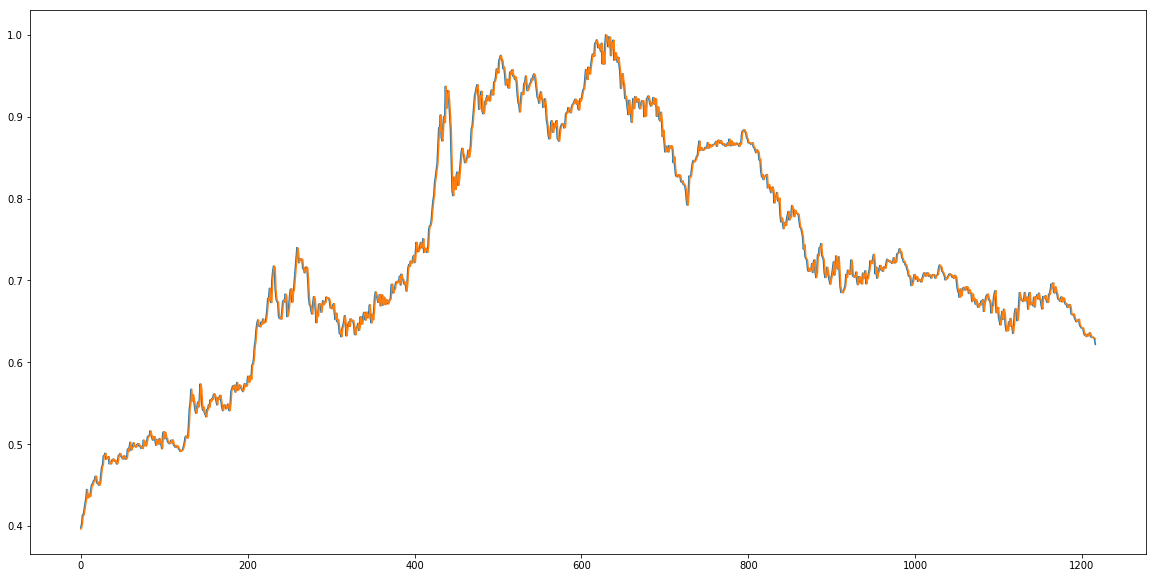

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(y_train)
plt.plot(x_train[:, -1])
plt.show()

In [30]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [31]:
x_train.shape

(1217, 20, 1)

In [32]:
model = Sequential()
model.add(CuDNNLSTM(50, input_shape=(None, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(CuDNNLSTM(100))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.compile(loss="mse", optimizer="adam", metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, None, 50)          10600     
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 100)         60800     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
__________

In [33]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_train.shape

(1217, 20, 1)

In [34]:
y_train = y_train.reshape(y_train.shape[0], 1)
y_train.shape

(1217, 1)

In [38]:
history = model.fit(x_train, y_train, epochs=1000, verbose=0, validation_split=0.2)

In [41]:
history1 = model.fit(x_train, y_train, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

Train on 912 samples, validate on 305 samples
Epoch 1/50
912/912 [==============================] - 1s 574us/step - loss: 1.3245e-04 - mean_absolute_error: 0.0089 - val_loss: 6.2159e-05 - val_mean_absolute_error: 0.0065
Epoch 2/50
912/912 [==============================] - 1s 552us/step - loss: 1.5283e-04 - mean_absolute_error: 0.0098 - val_loss: 1.3211e-04 - val_mean_absolute_error: 0.0099
Epoch 3/50
912/912 [==============================] - 1s 554us/step - loss: 1.6821e-04 - mean_absolute_error: 0.0102 - val_loss: 4.7286e-05 - val_mean_absolute_error: 0.0055
Epoch 4/50
912/912 [==============================] - 1s 559us/step - loss: 1.9316e-04 - mean_absolute_error: 0.0111 - val_loss: 4.5516e-05 - val_mean_absolute_error: 0.0052
Epoch 5/50
912/912 [==============================] - 1s 555us/step - loss: 1.6945e-04 - mean_absolute_error: 0.0103 - val_loss: 5.7083e-05 - val_mean_absolute_error: 0.0061
Epoch 6/50
912/912 [==============================] - 1s 568us/step - loss: 1.8189e-

In [44]:
print(history1.history)

{'val_loss': [6.215874105453354e-05, 0.00013210830979095008, 4.72864105326093e-05, 4.5515901431036715e-05, 5.708259054923384e-05, 4.406914509285134e-05, 0.0001746095916572455, 4.476541548310855e-05, 6.870471747974914e-05, 0.00023325428129417143, 4.850422503564079e-05, 9.838999116269763e-05, 6.593699337051967e-05, 4.2368245853080615e-05, 4.942804917532829e-05, 0.00010071774562019244, 4.3649113995641406e-05, 5.7484275856070585e-05, 4.18172772309636e-05, 9.218744731309717e-05, 5.29554110024216e-05, 4.63416798948692e-05, 4.274486103686733e-05, 0.00011756418730254185, 4.770852111043317e-05, 0.00012140171769357545, 3.9649642641335484e-05, 5.2729884227432433e-05, 5.3048226742308154e-05, 4.616184952119213e-05, 5.462054121708803e-05, 4.0533574017482336e-05, 3.7243377038499064e-05, 4.239823336648129e-05, 4.4915113790384416e-05, 4.612973916962682e-05, 8.11650162013095e-05, 6.290922298279331e-05, 9.403195905835047e-05, 5.069247800732779e-05, 4.551400579359444e-05, 4.298607570684103e-05, 4.13867865

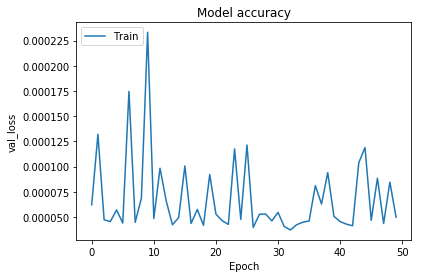

In [45]:
# Plot training & validation accuracy values
plt.plot(history1.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

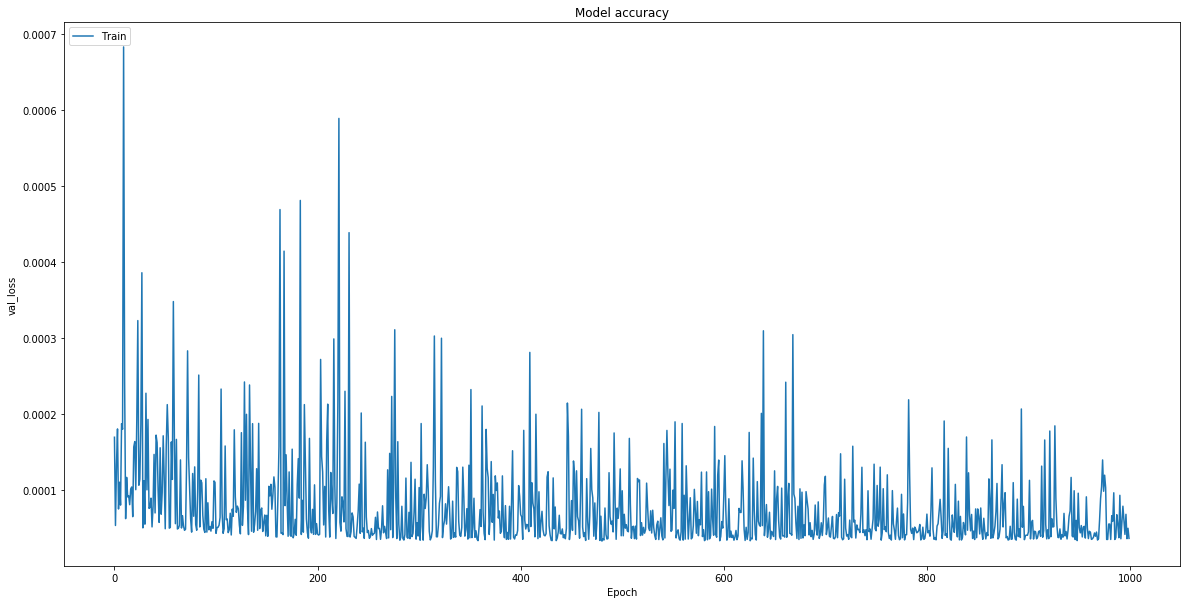

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [51]:
model2 = Sequential()
model2.add(CuDNNLSTM(50, input_shape=(None, 1), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(CuDNNLSTM(100, return_sequences=True))
model2.add(Dropout(0.4))
model2.add(CuDNNLSTM(100))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='tanh'))
model2.add(Dense(20, activation='tanh'))
model2.add(Dense(1, activation='linear'))
model2.compile(loss="mse", optimizer="adam", metrics=['acc'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    (None, None, 50)          10600     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, None, 100)         60800     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 100)               80800     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
__________

In [52]:
history2 = model2.fit(x_train, y_train, validation_split=0.25, epochs=3000, batch_size=20, verbose=0)

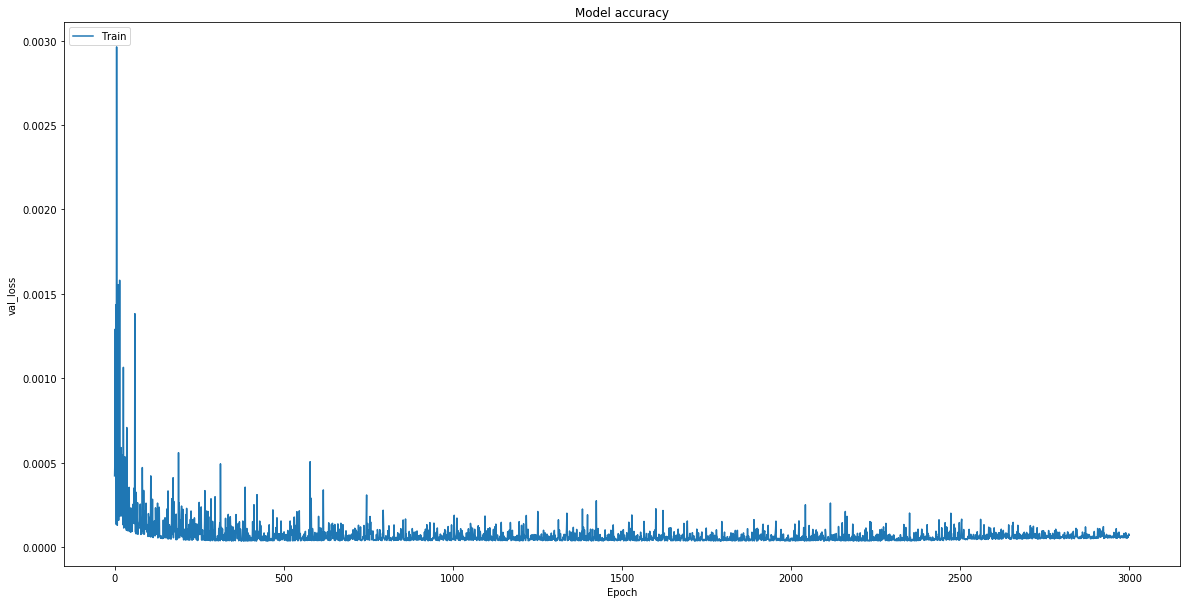

In [53]:
plt.figure(figsize=(20, 10))
plt.plot(history2.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [55]:
model2.save("model2.h5")

# 再次训练

In [56]:
from tensorflow.python.keras.models import load_model
model2_sec = load_model("model2.h5")
history2_sec = model2_sec.fit(x_train, y_train, validation_split=0.25, epochs=500, batch_size=20, verbose=0)

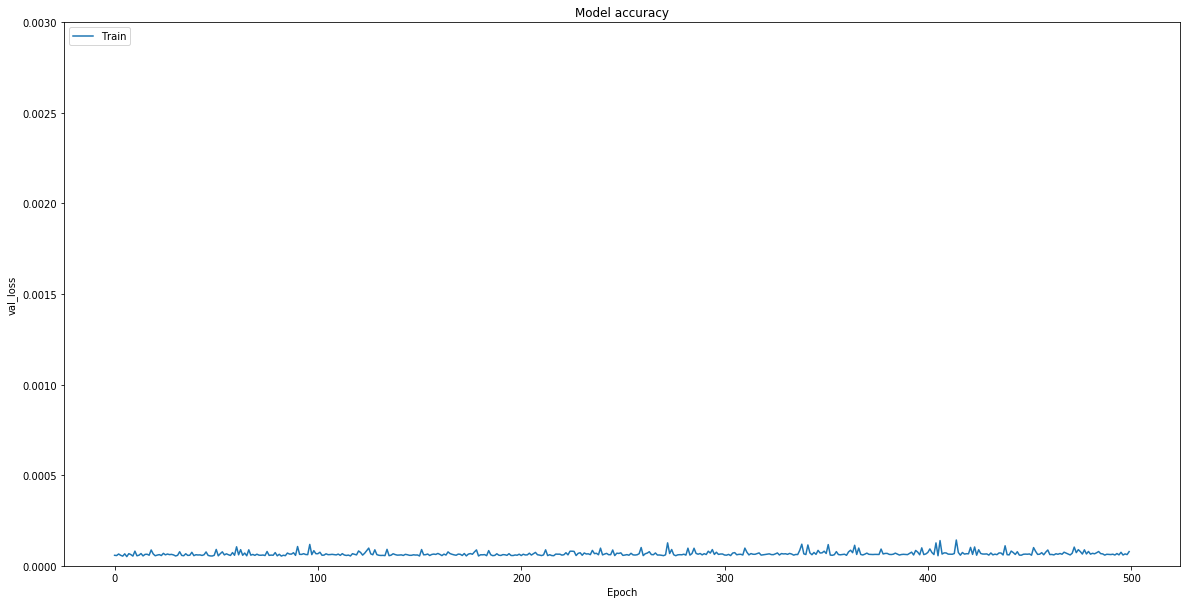

In [57]:
plt.figure(figsize=(20, 10))
plt.plot(history2_sec.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.ylim(0.0000, 0.0030)
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [61]:
plt.figure(figsize=(20, 10))
plt.plot(all_history2_loss)
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.ylim(0.0000, 0.0030)
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

ValueError: x, y, and format string must not be None

In [ ]:
x_train[0, :, :]

In [ ]:
y_train[0, :]

In [ ]:
model.predict(x_train[0, :, :].reshape(1, 20, 1))